In [33]:
# open accelData pickle
import pickle
with open('drive/MyDrive/Pickles/accelData.pickle', 'rb') as handle:
    accelData = pickle.load(handle)

In [34]:
# Remove time column from accelData Measurements
accelData['Measurements with Time'] = accelData['Measurements']

for i in range(len(accelData['Measurements'])):
    accelData['Measurements'][i] = accelData['Measurements'][i].iloc[:, 1:]

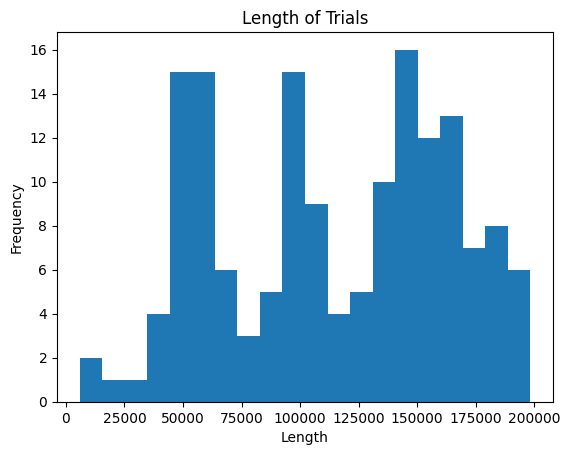

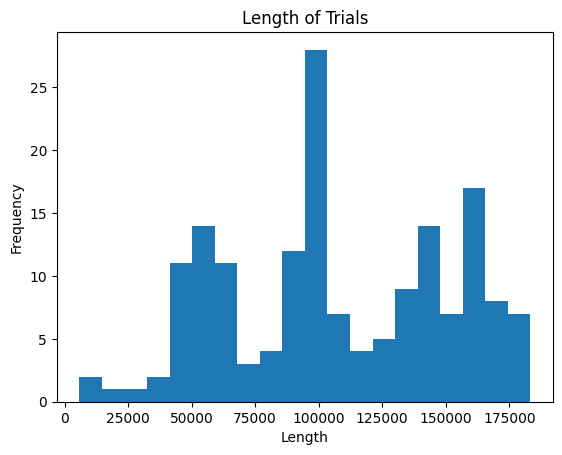

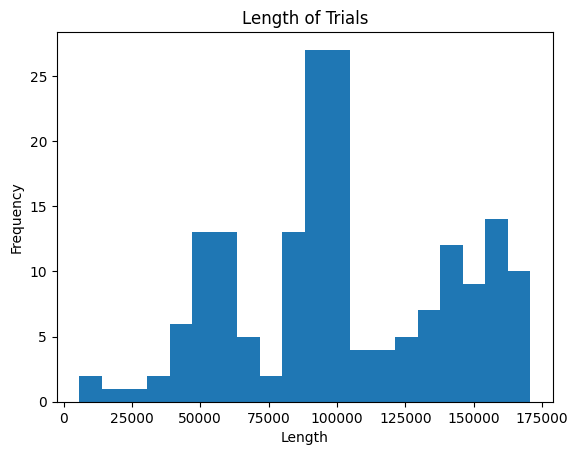

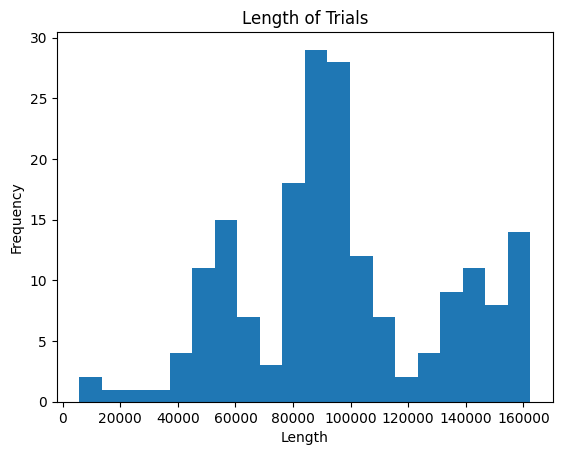

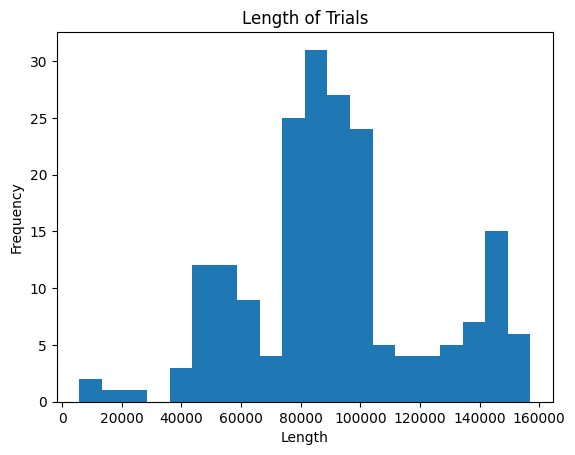

In [35]:
# Necessary imports
import numpy as np
import matplotlib.pyplot as plt
for i in range(5):
    K = 10

    # Split some of the longer trials in half
    numRowsAccel = [df.shape[0] for df in accelData['Measurements']]
    sortedIndices = np.argsort(numRowsAccel)

    # Get the indices of the top k dataframes
    topKIndices = sortedIndices[-K:]

    # Get the top k dataframes
    topKDataframes = [accelData['Measurements'][i] for i in topKIndices]

    # Get the top k corresponding months, IDs, labels
    topKMonths = [accelData['Month'][i] for i in topKIndices]
    topKCodes = [accelData['Code'][i] for i in topKIndices]
    topKAbnormal = [accelData['Abnormal'][i] for i in topKIndices]
    topKAIMS = [accelData['AIMS'][i] for i in topKIndices]
    topKOptimality = [accelData['Optimality'][i] for i in topKIndices]

    # Remove the dataframes from accelData
    for i in sorted(topKIndices, reverse=True):
        del accelData['Measurements'][i]
        del accelData['Month'][i]
        del accelData['Code'][i]
        del accelData['Abnormal'][i]
        del accelData['AIMS'][i]
        del accelData['Optimality'][i]

    # Split the top k dataframes into two and reinsert into structure
    for i in range(len(topKDataframes)):
        df = topKDataframes[i]
        month = topKMonths[i]
        code = topKCodes[i]
        abnormal = topKAbnormal[i]
        aims = topKAIMS[i]
        optimality = topKOptimality[i]
        
        first_half = df.iloc[0:df.shape[0]//2]
        second_half = df.iloc[df.shape[0]//2:df.shape[0]]
        
        # Append the first and second halves to accelData
        accelData['Measurements'].append(first_half)
        accelData['Measurements'].append(second_half)
        
        # Append the corresponding values for month, code, abnormal, aims, and optimality
        accelData['Month'].extend([month, month])
        accelData['Code'].extend([code, code])
        accelData['Abnormal'].extend([abnormal, abnormal])
        accelData['AIMS'].extend([aims, aims])
        accelData['Optimality'].extend([optimality, optimality])

    # PLot histogram of length of trials
    lengths = [len(accelData['Measurements'][i]) for i in range(len(accelData['Measurements']))]
    plt.hist(lengths, bins=20)
    plt.title("Length of Trials")
    plt.xlabel("Length")
    plt.ylabel("Frequency")
    plt.show()
        
    # Memory management
    del numRowsAccel, sortedIndices, topKIndices, topKDataframes, topKMonths, topKCodes, topKAbnormal, topKAIMS, topKOptimality, first_half, second_half, df, month, code, abnormal, aims, optimality

In [36]:
# Normalise each trial so that amplitude is between 0 and 1
for i in range(len(accelData['Measurements'])):
    accelData['Measurements'][i] = (accelData['Measurements'][i] - accelData['Measurements'][i].min()) / (accelData['Measurements'][i].max() - accelData['Measurements'][i].min())


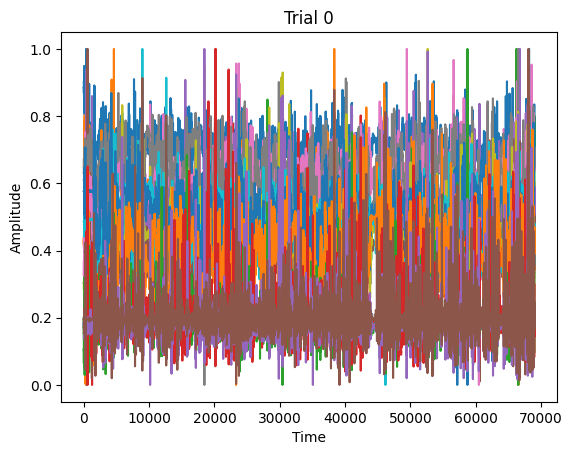

In [37]:
# visualise the data
import matplotlib.pyplot as plt

# Plot the first 10 trials
for i in range(1):
    plt.plot(accelData['Measurements'][i])
    plt.title("Trial " + str(i))
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.show()

In [38]:
import pandas as pd
# Add padding to smoothed (mean) then normalised and smoothed(median) then normalised dataframes

# Get the maximum number of rows in the dataframes
maxRows = max([df.shape[0] for df in accelData['Measurements']])
print("Max number of rows in the dataframes:", maxRows)
# Get the number of columns in the dataframes
numCols = accelData['Measurements'][0].shape[1]

accelData['Padded'] = accelData['Measurements'].copy()

# Add padding to the dataframes in accelData['Smoothed (mean) then Normalised']
for i in range(len(accelData['Measurements'])):
    df = accelData['Measurements'][i]
    padding = pd.DataFrame(np.zeros((maxRows - df.shape[0], numCols)), columns=df.columns)
    df = df.append(padding, ignore_index=True)
    accelData['Padded'][i] = df


Max number of rows in the dataframes: 157009


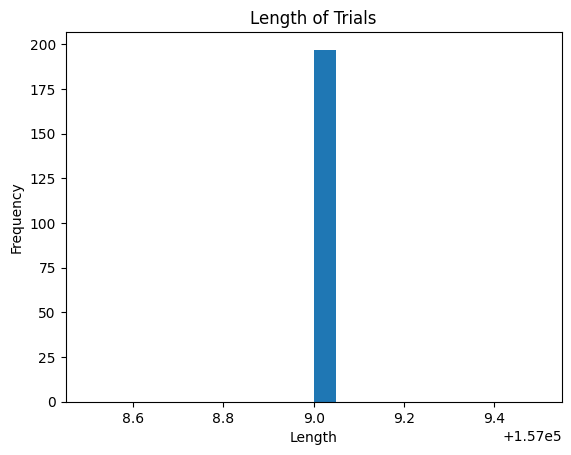

In [39]:
 # PLot histogram of length of trials
lengths = [len(accelData['Padded'][i]) for i in range(len(accelData['Padded']))]
plt.hist(lengths, bins=20)
plt.title("Length of Trials")
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.show()

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft
from scipy.signal.windows import hann

# Assuming `accelData['Padded']` is a list of DataFrames, each containing accelerometer data for a trial
# with columns named 'AccX<limb>', 'AccY<limb>', 'AccZ<limb>', and 'AccSum<limb>'

fs = 100  # Sampling frequency
numTrials = len(accelData['Padded'])  # Number of trials
accelData['FFT'] = []  # List to store FFT data for each trial

for trial in range(numTrials):  # This example focuses on plotting for the first trial, but can be adapted for more
    df = accelData['Padded'][trial]  # DataFrame for the current trial
    numRows = df.shape[0]  # Number of rows in the dataframe
    numFreqs = numRows // 2 + 1  # Number of frequency bins
    f = np.linspace(0, fs / 2, numFreqs)  # Frequency bins

    # Define limb strings
    limbStrings = ['RA', 'LA', 'RW', 'LW']
    fftDataList = []
    trialFFTs = {}
    
    # Apply FFT and plot for each limb's AccSum
    for limb in limbStrings:
        accSumColumn = f'AccSum{limb}'  # Name of the column for AccSum of the current limb
        
        # Window function to minimize spectral leakage
        window = hann(numRows)
        
        # Apply window and FFT on the AccSum column
        data_windowed = df[accSumColumn] * window
        fftData = np.abs(fft(data_windowed))[:numFreqs]  # Taking the magnitude of the FFT and selecting half (positive frequencies)

        if trial == 0:
        
            plt.figure(figsize=(10, 6))
            plt.semilogy(f, fftData)
            plt.title(f"FFT of {limb} AccSum - Trial {trial+1}")
            plt.xlabel("Frequency (Hz)")
            plt.ylabel("Magnitude (log scale)")
            plt.grid(True)
            plt.show()

        # Store the FFT for this limb
        trialFFTs[limb] = fftData
    
    # Append the FFT data for the current trial to the list
    accelData['FFT'].append(trialFFTs)


# combine frequency domain data for all 4 limbs so that we have a single input for each trial of shape (78505, 16)
accelData['CombinedFFTs'] = []
for i in range(len(accelData['FFT'])):
    trial = accelData['FFT'][i]
    combined = np.concatenate((trial['RA'], trial['LA'], trial['RW'], trial['LW']), axis=1)
    accelData['CombinedFFTs'].append(combined)

# Print the shape of the combined frequency domain data
print("Shape of the combined frequency domain data:", accelData['CombinedFFTs'][0].shape)
    


KeyError: 'ALIGNED'

In [29]:
print(len(accelData['Abnormal']))

591


In [ ]:
# one hot encoding of abnormal
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
abnormal = np.array(accelData['Abnormal']).reshape(-1, 1)
enc.fit(abnormal)
abnormal = enc.transform(abnormal).toarray()
accelData['Abnormal'] = abnormal



In [12]:
# Print the shape of the frequency domain data
print("Shape of the frequency domain data:", accelData['FFTs'][0]['RA'].shape)
print("Shape of the frequency domain data:", accelData['FFTs'][0]['LA'].shape)
print("Shape of the frequency domain data:", accelData['FFTs'][0]['RW'].shape)
print("Shape of the frequency domain data:", accelData['FFTs'][0]['LW'].shape)

Shape of the frequency domain data: (78505, 4)
Shape of the frequency domain data: (78505, 4)
Shape of the frequency domain data: (78505, 4)
Shape of the frequency domain data: (78505, 4)


In [13]:
# combine frequency domain data for all 4 limbs so that we have a single input for each trial of shape (78505, 16)
accelData['CombinedFFTs'] = []
for i in range(len(accelData['FFTs'])):
    trial = accelData['FFTs'][i]
    combined = np.concatenate((trial['RA'], trial['LA'], trial['RW'], trial['LW']), axis=1)
    accelData['CombinedFFTs'].append(combined)

# Print the shape of the combined frequency domain data
print("Shape of the combined frequency domain data:", accelData['CombinedFFTs'][0].shape)

Shape of the combined frequency domain data: (78505, 16)


In [44]:
# Use 'combinedFFTs' as input to a neural network to predict 'abnormal' 
# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X = np.array(accelData['CombinedFFTs'])
y = np.array(accelData['Abnormal'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Necessary imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Define the model
model = keras.Sequential([
    layers.Input(shape=(X_train.shape[1], X_train.shape[2])),
    layers.Conv1D(filters=64, kernel_size=3, activation='relu'),
    layers.Conv1D(filters=64, kernel_size=3, activation='relu'),
    layers.MaxPooling1D(pool_size=2),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(3, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot the training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


IndexError: tuple index out of range

In [19]:
# Train a CNN model to classify data as normal or abnormal
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Define the number of classes
numClasses = 3

# Define the number of trials
numTrials = len(accelData['FFTs'])

# Define the number of limbs
numLimbs = 4

# Define the number of frequency bins
numFreqs = accelData['FFTs'][0]['RA'].shape[0]

# Define the number of columns
numCols = numLimbs * numFreqs

# Create an empty array to store the input data
X = np.empty((numTrials, numLimbs, numFreqs))

# Create an empty array to store the output data
y = np.empty((numTrials, numClasses))

# Create test and train data
for i in range(numTrials):
    # Get the FFTs for this trial
    trialFFTs = accelData['FFTs'][i]

    # Create an empty array to store the input data for this trial
    trialX = np.empty((numLimbs, numFreqs))

    # Create an empty array to store the output data for this trial
    trialY = accelData['Abnormal'][i]

    # Concatenate the FFTs for each limb
    for j, limb in enumerate(trialFFTs.keys()):
        # Get the FFT for this limb
        fftData = trialFFTs[limb]

        # Store the FFT for this limb
        trialX[j] = fftData[:, 0]

    # Store the input data for this trial
    X[i] = trialX

    # Store the output data for this trial
    y[i] = trialY

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape the data
X_train = X_train.reshape(X_train.shape[0], numLimbs, numFreqs, 1)
X_test = X_test.reshape(X_test.shape[0], numLimbs, numFreqs, 1)

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(numLimbs, numFreqs, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(numClasses, activation='softmax'))


# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print("Test accuracy:", test_acc)

# Plot the training and validation accuracy
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')

plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()




ValueError: One of the dimensions in the output is <= 0 due to downsampling in conv2d_3. Consider increasing the input size. Received input shape [None, 1, 39251, 32] which would produce output shape with a zero or negative value in a dimension.